V tomto příkladu budeme pracovat s Bibliografií českého literárního exilu, která obsahuje záznamy o knihách a statích s literární tématikou, vydaných a publikovaných v českých exilových nakladatelstvích a časopisech. Nás budou zajímat pouze záznamy o statích, u kterých jsou uvedeni autor a časopis, ve kterém stať vyšla. Ty najdeme v polích 100 \$a (respektive 100 \$7) a 773 \$t. Notebook lze použít na všechny bibliografie. <br>
Ukážeme si, jak z dat získat jméno časopisu, jak data o autorech a časopisech následně zpracovat. Nakonec z nich vytvoříme strukturu bipartitního grafu, kterou vykreslíme pomocí knihovny matplotlib.    


#### Příprava 
Jako první si musíme nainstalovat knihovny, se kterými budeme pracovat. Knihovny jsou balíčky funkcí, které nejsou součástí základu jazyka python. <br>
Knihovny nainstalujeme pomocí příkazu `%pip install <jmeno_knihovny>` . Pak je do našeho notebooku přidáme pomocí příkazu `import <jmeno_knihovny> (as alias)`. K funkcím knihovny se pak přistupuje `jmeno_knihovny.jmeno_funkce` <br> 
Pokud z knihovny chceme využít pouze jednu funkci, přidáme ji pomocí `from <jmeno_knihovny> import <jmeno_funkce>`

In [1]:
%pip install matplotlib
%pip install networkx
%pip install numpy
%pip install pandas

from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Načtení dat

Nejprve načteme naše uložená csv data. Jak převést marcovou databázi do csv tabulky a pak csv tabulku načíst jsme si ukázali v předchozím příkladu. Csv tabulku z markové databáze lze vygenerovat i pomocí skriptu save_csv.py.

In [2]:

# Cesta k nasim datum
csv_data = 'data/csv/out_cle.csv'

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


Podíváme, jak naše data v tabulce vypadají. Nejprve si vypíšeme, kolik záznamů obsahuje informaci o časopisu. To jsou záznamy o statíh, které nás budou zajímat. Zbylé budeme považvat za záznamy o knihách. Pak si vypíšeme prvních 5 a posledních 5 položek v DataFramu.

In [3]:
# Spocteme radky, ktere v maji nejakou  hodnotu
magazines_counts = df['magazine'].apply(lambda x: 1 if len(x) > 0 else 0)

sum_magazines_counts = magazines_counts.sum()

print("Počet záznamů o statích: ", sum_magazines_counts)

sum_books_counts = len(df) - sum_magazines_counts

print("Počet záznamů o knihách: ", sum_books_counts)

# Vypise prvnich 5 zaznamu v DataFramu
print(df.head())
print("----------------------------------------------------------------------------------------------------")

# Vypise poslednich 5 zaznamu v DataFramu
print(df.tail())

Počet záznamů o statích:  7953
Počet záznamů o knihách:  1659
                                  title               author      author code  \
0                [Kultura je když... /]  [Kliment, Alexandr]     [jk01060558]   
1                       [Hra o život /]   [Dobrovský, Luboš]  [jn20000400479]   
2          [Památce Bohuslava Reynka /]    [Jirousová, Věra]  [jn19990218035]   
3           [Joyceův zkušební návrat /]    [Urbánek, Zdeněk]     [jk01140872]   
4  [Čas jako trvání a jako prázdnota /]      [Černý, Václav]     [jk01021636]   

   year             figures             description     genre    magazine  
0  1978                  []              [estetika]   [úvahy]  [Spektrum]  
1  1978    [Kundera, Milan]           [česká próza]  [studie]  [Spektrum]  
2  1978  [Reynek, Bohuslav]     [čeští spisovatelé]  [studie]  [Spektrum]  
3  1978      [Joyce, James]  [anglicky psané drama]  [studie]  [Spektrum]  
4  1979                  []              [estetika]   [eseje]  [Spektru

Abychom nemuseli psát stejný kód několikrát, napíšeme ho jednou do funkce, kterou pak jednoduše zavoláme. V tomto případě si napíšeme funkci, která nám z několika listů (seznamů) vnořených do sebe vytvoří jeden. To se nám bude hodit, až budeme chtít spočítat četnost. 

In [4]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    if strings is not None: # Zkontrolujeme, jestli element neni None
        for item in strings:
            if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
                flattened_list.append(item)
            elif isinstance(item, list):  # Rekurzivne zavola sebe
                flattened_list.extend(flatten_list(item))
        return flattened_list

### Extrahování a čištění dat

K časopisu je zpravidla připsáno i místo vydání. Pro naše účely nám stačí ale jen název časopisu. Proto pomocí regulárního výrazu (regex) odstraníme místo vydání, které je napsané v kulatých, nebo hranatých závorkách.

In [6]:
# regex patern, ktery najde substring pred zavorkou
# r"^(.*?)\s*(?=\()" <- kulate zavorky
pattern_magazine = r"^(.*?)\s*(?=\()"   #r"(.*?)\[" # <- hranate zavory  

# Odstranime misto vydani v zavore (pokud je pritomno)
df['magazine'] = df['magazine'].apply(lambda x: [re.search(pattern_magazine, y).group(1) if re.search(pattern_magazine, y) else y for y in x])

# Zbavime se prebytecnych mezer na zacatku a na konci stringu
df['magazine'] = df['magazine'].apply(lambda x: [y.rstrip() for y in x])

# Unikatni casopisy
unique_magazine = np.unique(flatten_list(df.magazine))
print(unique_magazine)

print("Počet časopisů v bibliografii je: " + str(len(unique_magazine)))

['150 000 slov' 'Acta' 'Archa' 'Bohemia' 'Demokracia v exile'
 'Demokracie v exilu' 'Hlas exilu'
 'Information Service of Free Czechoslovakia'
 'Kalendář československého exilu'
 'Klub : informace Klubu čtenářů CCC Books' 'Listy' 'Magazín'
 'Modrá revue' 'Most a.t.d.' 'Naši v Holandsku' 'Nové obzory' 'Nový život'
 'Národní politika' 'Obrys' 'Okno dokořán' 'Paternoster' 'Perspektivy'
 'Premeny' 'Proměny' 'Právo lidu' 'Reportér' 'Rozmluvy' 'Sborník Bohemia'
 'Sklizeň' 'Sklizeň svobodné tvorby' 'Skutečnost' 'Spektrum' 'Spektrum :'
 'Studie' 'Svědectví' 'Telegram' 'Text' 'Zpravodaj'
 'Zpravodaj : sdružení čs. politických uprchlíků v Německu - Sdruženie čs. politických ubehlíkov v Německu'
 'Zvon' 'Západ' 'Zápisník' 'příl. Dokumentace Charty 77 1983'
 'příl. Knižní jídelníček' 'příl. časopisu Modrá revue'
 'Čechoslovák v zahraničí' 'Československý přehled' 'Česká příloha'
 'České slovo']
Počet časopisů v bibliografii je: 49


#### Zpracování

Abychom mohli vytvořit graf, musíme data v tabulce zpracovat. V grafu chceme zobrazit deset nejčetnějších autorů a k nim přiřadit časopisy, do kterých autoři přispívali. V tomto příkladu pracujeme s unikátním kódem autora, ke kterému až později přiřadíme skutečné jméno. Je to kvůli tomu, abychom odstranili nežádoucí záznamy, jako jsou například články, které psala celá redakce časopisu. Ty žádné kódy přiřazené nemá. V našem příkladu se zajímáme jen o konkrétní osoby. <br>    
Nejprve musíme zjistit všechny autory, kteří se v bibliografii objevují. Spočteme jejich četnosti a vybereme jen 10 nejčastějších. U těch najdeme indexy řádků, ve kterých se autoři vyskytovali. Podle indexů pak najdeme všechny časopisy, do kterých nejčastějších 10 autorů přispívalo.

Pozn.: Pomocí toho kódu lze zobrazit i jiné vztahy dvou sloupců, např. kteří autoři psali o jakých osobnostech (figures).

přidat ukázku

In [17]:

author_code_column = 'author code'

# Vsichni autori ve sloupci
all_authors = flatten_list(df[author_code_column])

# Spocteme, v kolika zaznamech se autor objevil
counted_authors = Counter(all_authors)

# Pocet uzlu, ktere chceme vykreslit
n = 10

# Najdeme nejcastejsi autory, ktere pak zobrazime
most_common_authors = [item[0] for item in counted_authors.most_common(n)]

# Sloupec, ktery chceme zobrazit.
column =  'magazine'

# Zjistime indexy vsech radku, kde se objevuji autori, ktere chceme zobrazit    prepsat do smycky
ind = [True if any([True if author in most_common_authors else False for author in author_list]) else False for author_list in df[author_code_column]]

# 
author_elements = df[ind][column]

unique_author_elements = np.unique(flatten_list(author_elements)) 

#### Mapping

Přiřadíme ke kódu autora jeho jméno.

In [18]:
mapping = {}
most_common_authors_copy = most_common_authors.copy()
for idx,row in df.iterrows():
        if any(item in most_common_authors_copy for item in row[author_code_column]):
                for i, item in enumerate(row[author_code_column]):
                        if item in most_common_authors_copy:
                                mapping[item] = row['author'][i]
                                most_common_authors_copy.remove(item)
        if len(most_common_authors_copy)<1:
                break                                

#### Vytvoření struktury grafu

Strukturu grafu vytvoříme pomocí knihovny networkx, kam jen přidáme dvě sady uzlů - autory a časopisy, a k nim vážené hrany - počet napsaných článků do daného časopisu. Abychom graf neměli přehlecený, omezíme počet časopisů a vykreslených hran na ty nejčetnější.  


In [21]:
# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(most_common_authors, bipartite=1)

# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Iterujeme pres vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for author in row[author_code_column]:
            # Chceme vyselektovat jen desen nejcastejsich elemenu a casopisu
            if element in unique_author_elements and author in most_common_authors:
                if  (author, element) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(author, element)] += 1
                else:
                    edge_weights[(author, element)] = 1

# Vykreslime jen ty casopisy, ktere se objevuji vicekrat  
threshold = 10
left = []

for edge, weight in edge_weights.items():
    if weight>threshold:
        if ~G.has_node(edge[1]):
            left.append(edge[1])
            G.add_node(edge[1], bipartite=0) 
        G.add_edge(edge[0], edge[1], weight=weight)                

# Ke kodu autora pridame jeho skutecne jmeno
G = nx.relabel_nodes(G, mapping)

#### Vykreslení grafu

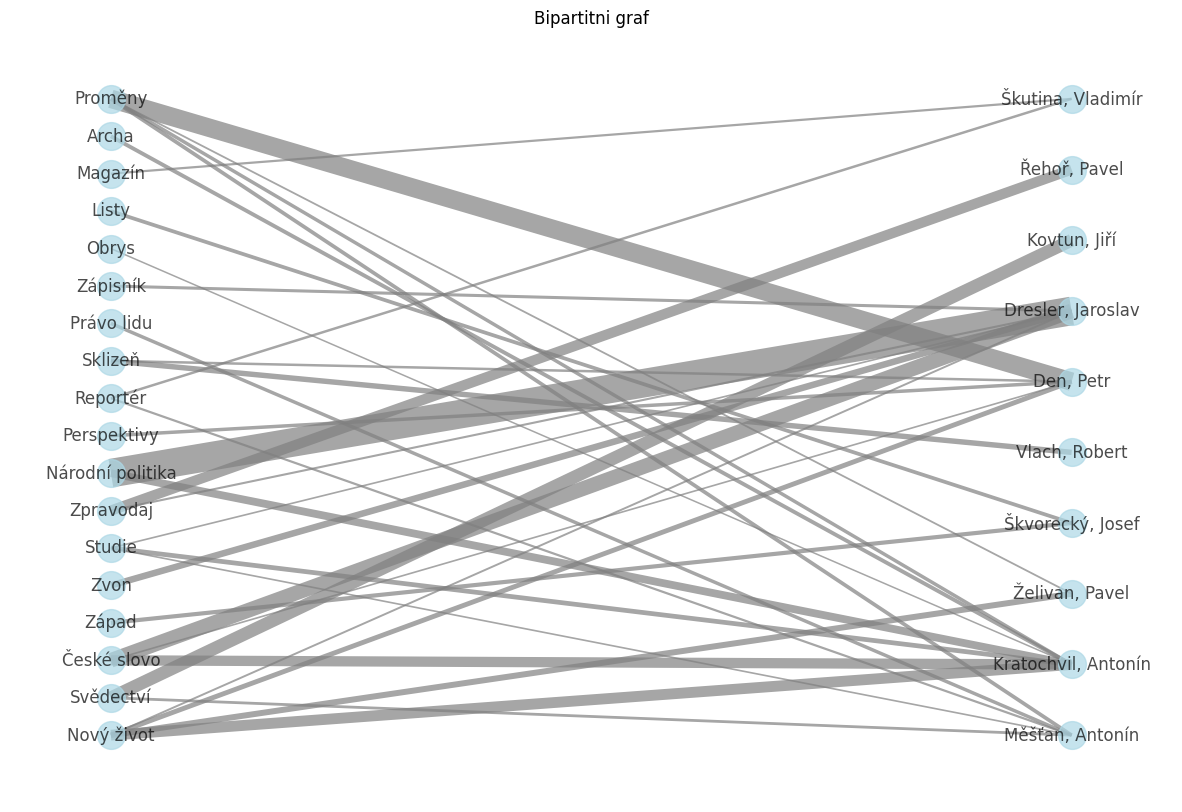

In [22]:
pos = nx.bipartite_layout(G, nodes = left)
plt.figure(figsize=(15, 10))
edge_widths = [0.1 * G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.show()

Vysvětlení